In [1]:
pip install boruta

In [2]:
!nvidia-smi

Fri Jul 14 19:08:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
# from google.colab import files
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import joblib

In [ ]:
#df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/transaction_2021.parquet')
#df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/transaction 2021.xlsx')

In [ ]:
#df2 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/transaction_2022.parquet')
#df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/transaction 2022.xlsx')

In [ ]:
#df3 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/transaction_2023.parquet')
#df3 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/transaction 2023.xlsx')

In [ ]:
#df_all = pd.concat([df, df2, df3])
#df_all = pd.concat([df])

In [ ]:
# # Read Data
# df21 = pd.read_parquet('transaction_2021.parquet')
# df22 = pd.read_parquet('transaction_2022.parquet')
# df23 = pd.read_parquet('transaction_2023.parquet')
# df_all = pd.concat([df21, df22, df23])

# Data Preparation

In [3]:

# a = df_all["product_json"].to_list()

# lst = []

# try:
#     for i in a:
#       if str(i)=='nan':
#         break
#       dct = json.loads(i)
#       for j in dct:
#           lst.append(j["product"])
# except ValueError:
#     print("That item does not exist")

In [4]:
# len(lst)

In [5]:
# df_product = pd.DataFrame(data=lst, columns=["product"])
# df_product_group = df_product.groupby(["product"]).count().reset_index()
# df_product_list = df_product_group["product"].to_list()
# len(df_product_list)


In [6]:
# df_test = df.copy()
# df_test['product'] = df_test['product_json'].apply(lambda x: [item['product'] for item in eval(x)])
# df_test['qty'] = df_test['product_json'].apply(lambda x: [item['qty'] for item in eval(x)])

In [7]:

# for c in df_product_list:
#     # df_test[c] = 0
#     df_test[c] = df_test['product'].apply(lambda x: 1 if c in x else 0)

#     # print(f"c = {c}   {asd}")
#     # if df_test["product_json"].str.contains(c):
#     #     df_test[c] = 1
#     # else:
#     #     df_test[c] = 0

# Load Data

In [5]:
df_full = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/df_full.parquet')

In [6]:
#Drop some column
tns=df_full
tns=tns.drop(columns=['center','product_json','product','qty'])

In [7]:
tns.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_origin_type,0C1CC4,0C4C43,0C4C4C,0C4C4Q,...,XC4CCE,XC4CCQ,XC4CCW,XCECC4,XCECCJ,XCECCQ,XCJCC3,XCJCCZ,XCQCC4,XP9LI
0,2021-01-01 00:00:00.000,TCC43RQQZ3B,1627000.0,0.0,1627000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 00:00:00.000,TCC4Q4JZ4Q0,594000.0,0.0,594000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 00:00:00.000,TCC4RJ11QE7,468000.0,0.0,468000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 00:00:00.000,TCC434QRCJY,341000.0,0.0,341000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 00:00:00.000,TCC43RRCE10,189000.0,0.0,189000.0,online,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Change to Date format

tns['payment_date']=pd.to_datetime(tns['payment_date'])

# Create Features

In [9]:
tns1_6=tns[(tns['payment_date']>='2021-01-01') & (tns['payment_date']<='2021-06-30')]

In [10]:
#One Hot Encoding on Customer price sensitivity
one_hot_encoded = pd.get_dummies(tns1_6['trans_origin_type'], prefix='trans_type')
tns1_6 = pd.concat([tns1_6.iloc[:,:6], one_hot_encoded], axis=1)
tns1_6=tns1_6.drop(columns=['trans_origin_type'])

tns1_6.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_type_offline,trans_type_online
0,2021-01-01,TCC43RQQZ3B,1627000.0,0.0,1627000.0,0,1
1,2021-01-01,TCC4Q4JZ4Q0,594000.0,0.0,594000.0,0,1
2,2021-01-01,TCC4RJ11QE7,468000.0,0.0,468000.0,0,1
3,2021-01-01,TCC434QRCJY,341000.0,0.0,341000.0,0,1
4,2021-01-01,TCC43RRCE10,189000.0,0.0,189000.0,0,1


In [11]:
tns1_6['Discount']=(1-(tns1_6['paid_amount']/tns1_6['total_amount']))*100

tns1_6.head()

,payment_date,ent,total_amount,discount,paid_amount,trans_type_offline,trans_type_online,Discount
0,2021-01-01,TCC43RQQZ3B,1627000.0,0.0,1627000.0,0,1,0.0
1,2021-01-01,TCC4Q4JZ4Q0,594000.0,0.0,594000.0,0,1,0.0
2,2021-01-01,TCC4RJ11QE7,468000.0,0.0,468000.0,0,1,0.0
3,2021-01-01,TCC434QRCJY,341000.0,0.0,341000.0,0,1,0.0
4,2021-01-01,TCC43RRCE10,189000.0,0.0,189000.0,0,1,0.0


In [12]:
#Total Spen by Customer
features=tns1_6.groupby('ent')['total_amount'].sum().reset_index()

features.head()

,ent,total_amount
0,8C4ECCCCC3Y,823000.0
1,8CCCCCC4R1F,3798000.0
2,BC11JW3U,4579000.0
3,BCCCCRE3CZY,410000.0
4,BCCCCREW3WY,2567500.0


In [21]:
#features=features.drop(columns=['paid_amount_x', 'paid_amount_y'])

In [13]:
#Frequency
features['frequency']=list(tns1_6.groupby('ent')['ent'].count())

#Aver Spend per Trans
features['Avg_spend']=features['total_amount']/features['frequency']

#Total Paid
features=features.merge(tns1_6.groupby('ent')['paid_amount'].sum().reset_index(), on='ent', how='left')

In [14]:
#Discount
features=features.merge(tns1_6.groupby('ent')['Discount'].mean().reset_index(), on='ent', how='left')

In [15]:
features.head()

,ent,total_amount,frequency,Avg_spend,paid_amount,Discount
0,8C4ECCCCC3Y,823000.0,2,4.115000e+05,823000.0,0.0
1,8CCCCCC4R1F,3798000.0,2,1.899000e+06,3798000.0,0.0
2,BC11JW3U,4579000.0,11,4.162727e+05,4579000.0,0.0
3,BCCCCRE3CZY,410000.0,1,4.100000e+05,410000.0,0.0
4,BCCCCREW3WY,2567500.0,3,8.558333e+05,2567500.0,0.0


In [16]:
#Actual Paid Ratio
#features['tot_disc']=100-((features['paid_amount']/features['total_amount'])*100)

#Start date
features['startdate']=list(tns1_6.groupby('ent')['payment_date'].min())

#Last date
features['lastdate']=list(tns1_6.groupby('ent')['payment_date'].max())
features['lastdate']=pd.to_datetime(features['lastdate'])

In [ ]:
tns1_6.groupby('ent')['trans_type_online'].sum().reset_index()

,ent,trans_type_online
0,8C4ECCCCC3Y,1
1,8CCCCCC4R1F,2
2,BC11JW3U,3
3,BCCCCRE3CZY,0
4,BCCCCREW3WY,1
...,...,...
325622,TZZZJ3WP,5
325623,TZZZJZ4Y,0
325624,TZZZREZF,0
325625,TZZZW417,0


In [17]:
#Life time
features['total_time']=((features['lastdate']-features['startdate']).dt.days)+1

#MEAN TIME BETAWEEN PURCHASE
features['mtbp']=features['total_time']/features['frequency']


In [18]:
#Count offline
features=features.merge(tns1_6.groupby('ent')['trans_type_offline'].sum().reset_index(), on='ent', how='left')

#Count Online
features=features.merge(tns1_6.groupby('ent')['trans_type_online'].sum().reset_index(), on='ent', how='left')

In [19]:
# drop columns
features=features.drop(columns=['paid_amount', 'total_amount'])

In [20]:
features.head()

,ent,frequency,Avg_spend,Discount,startdate,lastdate,total_time,mtbp,trans_type_offline,trans_type_online
0,8C4ECCCCC3Y,2,4.115000e+05,0.0,2021-03-08,2021-05-03 08:39:00,57,28.500000,1,1
1,8CCCCCC4R1F,2,1.899000e+06,0.0,2021-02-24,2021-05-18 00:00:00,84,42.000000,0,2
2,BC11JW3U,11,4.162727e+05,0.0,2021-01-03,2021-04-06 00:00:00,94,8.545455,8,3
3,BCCCCRE3CZY,1,4.100000e+05,0.0,2021-04-28,2021-04-28 00:00:00,1,1.000000,1,0
4,BCCCCREW3WY,3,8.558333e+05,0.0,2021-05-04,2021-06-04 00:00:00,32,10.666667,2,1


# Data Preparation before K-Means

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [22]:
features.iloc[0:,1:]
# Create a sample DataFrame with multiple features
seg=features.drop(columns=['startdate','lastdate'])
seg=seg.iloc[0:,1:]

In [23]:
seg.isna().sum()

frequency                0
Avg_spend                0
Discount              2639
total_time               0
mtbp                     0
trans_type_offline       0
trans_type_online        0
dtype: int64

In [24]:
seg['Discount']=seg['Discount'].fillna(0)
seg

,frequency,Avg_spend,Discount,total_time,mtbp,trans_type_offline,trans_type_online
0,2,4.115000e+05,0.000000,57,28.500000,1,1
1,2,1.899000e+06,0.000000,84,42.000000,0,2
2,11,4.162727e+05,0.000000,94,8.545455,8,3
3,1,4.100000e+05,0.000000,1,1.000000,1,0
4,3,8.558333e+05,0.000000,32,10.666667,2,1
...,...,...,...,...,...,...,...
325622,20,1.125350e+06,1.521679,156,7.800000,15,5
325623,2,6.415000e+05,0.000000,62,31.000000,2,0
325624,15,5.108667e+05,0.000000,164,10.933333,15,0
325625,1,5.000000e+04,0.000000,1,1.000000,1,0


### Data Transformation
Transform Data to make data more Gaussian-like.
- The most common statistical assumption data scientists make is that their data is from a gaussian distibution, and furthermore many of the most common machine learning models are built upon that assumption. Because many ML tools require gaussian-like data the first check before implementing a model is to determine of the data is Gaussian-like.

Power transforms
- Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.
- Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.
- Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.
- By default, zero-mean, unit-variance normalization is applied to the transformed data.

*** Normality - Before transform ***
===== frequency =====
Statistics=0.560, p=0.000
Probably not Gaussian
===== Avg_spend =====
Statistics=0.879, p=0.000
Probably not Gaussian
===== Discount =====
Statistics=0.468, p=0.000
Probably not Gaussian
===== total_time =====
Statistics=0.654, p=0.000
Probably not Gaussian
===== mtbp =====
Statistics=0.632, p=0.000
Probably not Gaussian
===== trans_type_offline =====
Statistics=0.537, p=0.000
Probably not Gaussian
===== trans_type_online =====
Statistics=0.593, p=0.000
Probably not Gaussian


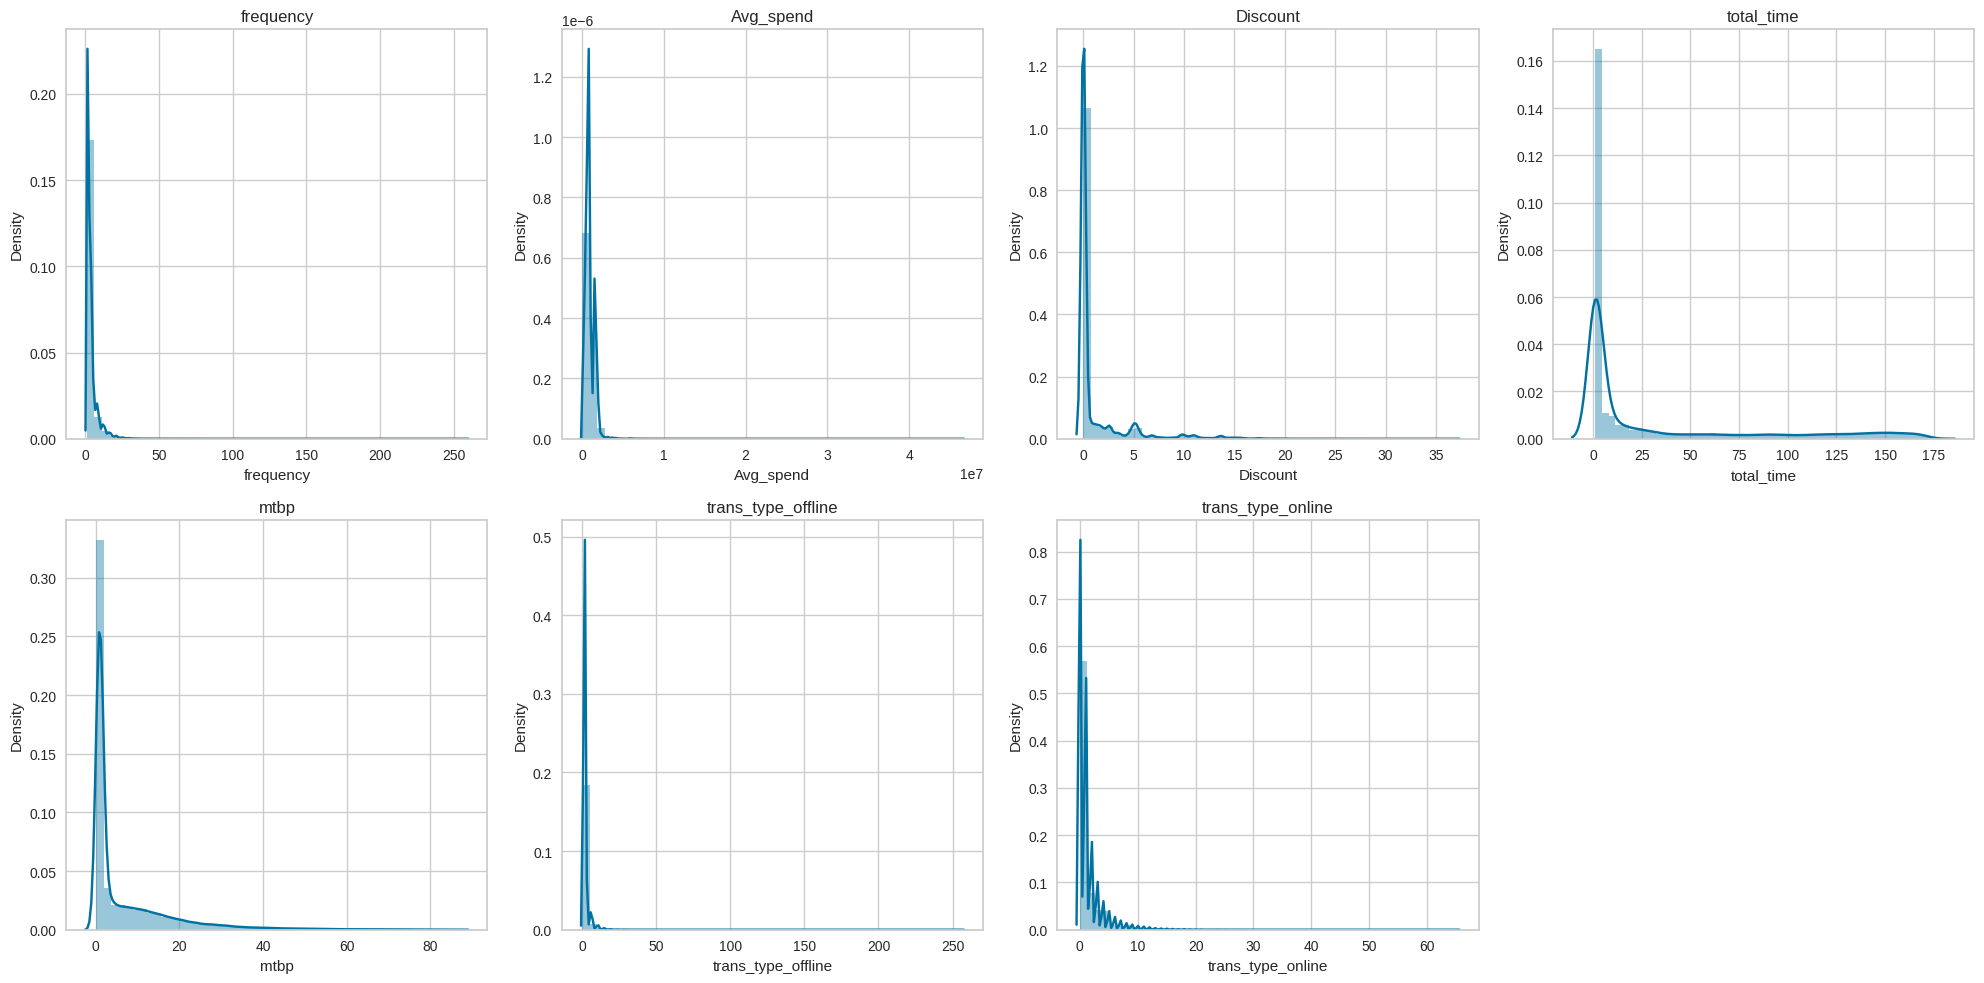

In [25]:
# def normal distribution test
def normality_test(df):
    from scipy.stats import shapiro
    for col in df.columns:
        stat, p = shapiro(df[col]) # shapiro test
        if p <= 0.05:
            print(f'===== {col} =====')
            print('Statistics=%.3f, p=%.3f' % (stat, p))
            print('Probably not Gaussian')

def distribution_plot(df):
    num_cols = len(df.columns)
    num_rows = (num_cols + 3) // 4  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 4, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.distplot(df[col], ax=ax[i//4, i%4])
        ax[i//4, i%4].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 4:
        for j in range(num_cols % 4, 4):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

print('*** Normality - Before transform ***')
normality_test(seg)
distribution_plot(seg)

*** Normality - After transform ***


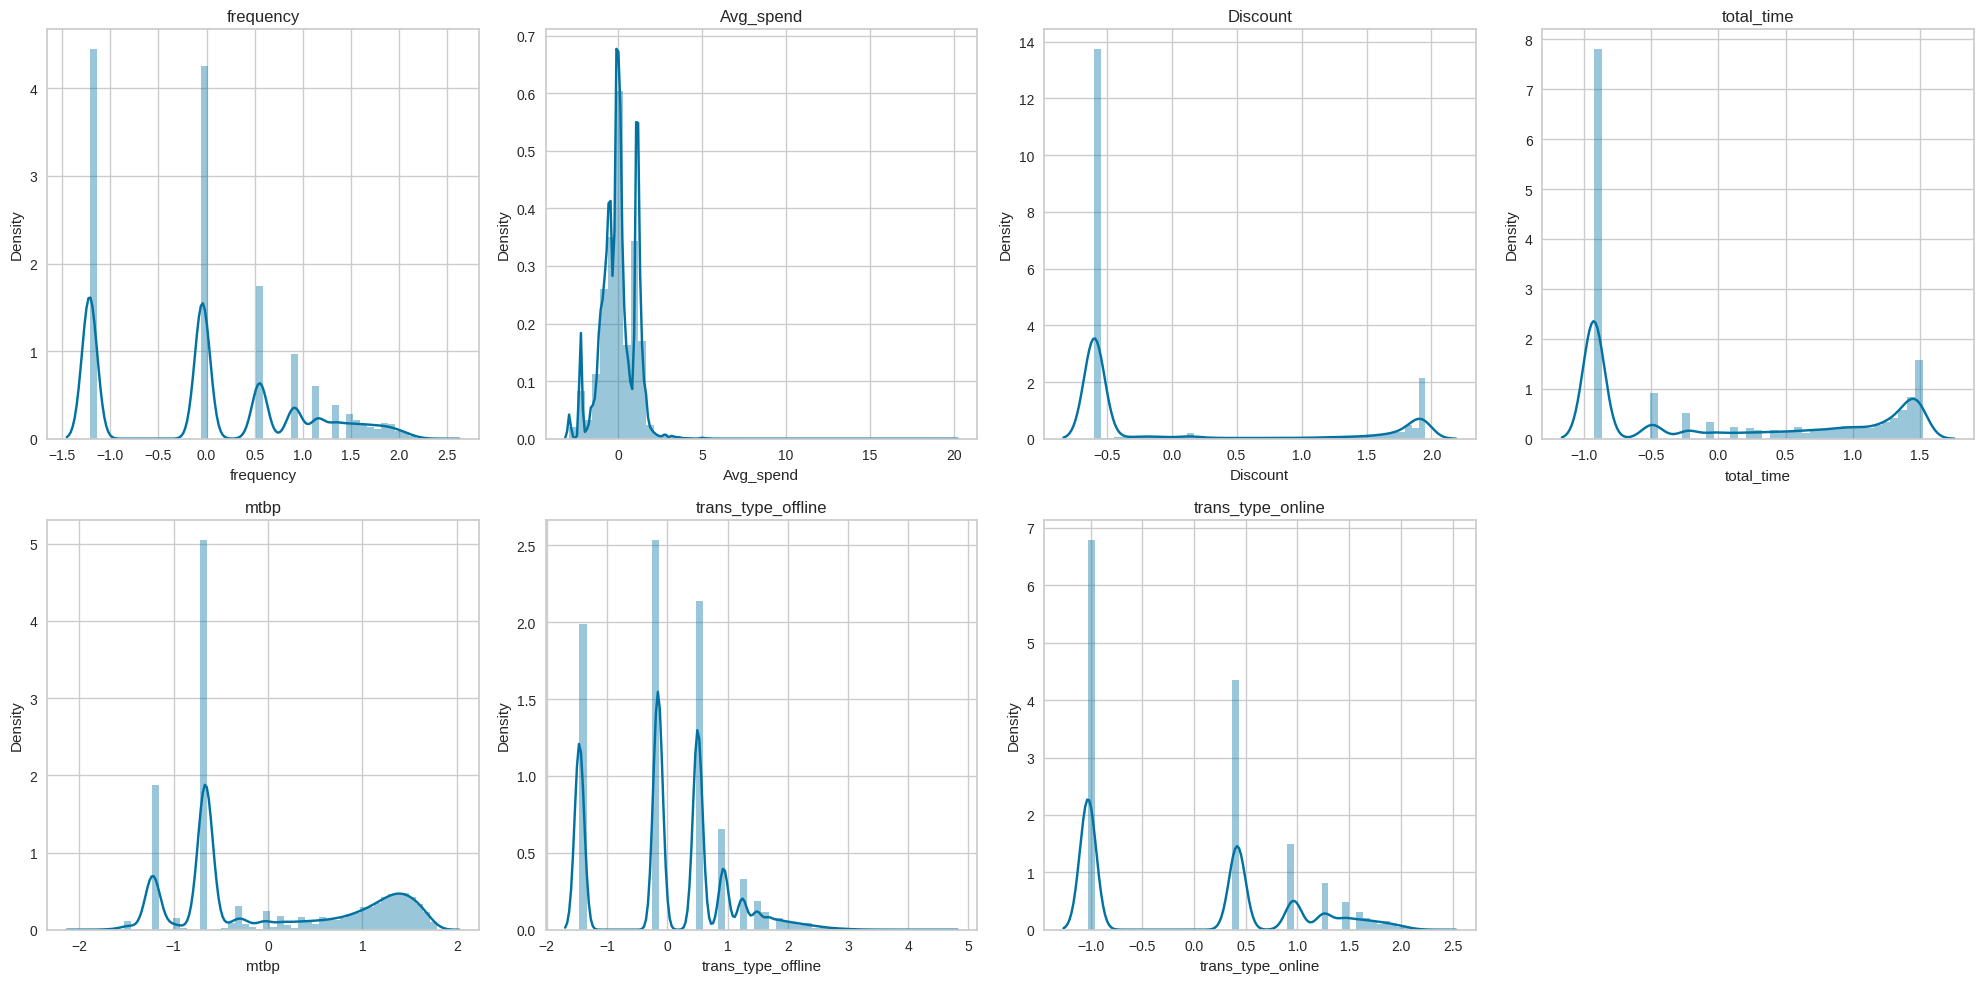

In [26]:
# power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() #default=’yeo-johnson’
seg_transform = pd.DataFrame(pt.fit_transform(seg))
seg_transform.columns = seg.columns

print('*** Normality - After transform ***')
# normality_test(seg_transform)
distribution_plot(seg_transform)


In [50]:
seg_transform.head()

,frequency,Avg_spend,tot_disc,total_time,mtbp,trans_type_offline,trans_type_online
0,5.684342e-14,-0.747320,-0.594791,1.243414,1.243414,-0.154797,0.417359
1,5.684342e-14,0.766642,-0.594791,1.353144,1.353144,-1.458681,0.962281
2,5.684342e-14,1.001616,-0.594791,1.382097,1.382097,1.982462,1.256679
3,5.684342e-14,-1.245339,-0.594791,-0.927826,-0.927826,-0.154797,-1.024244
4,5.684342e-14,0.313680,-0.594791,1.048157,1.048157,0.505866,0.417359


# Elbow Method

Elbow Method to determine the number of clusters to be formed:


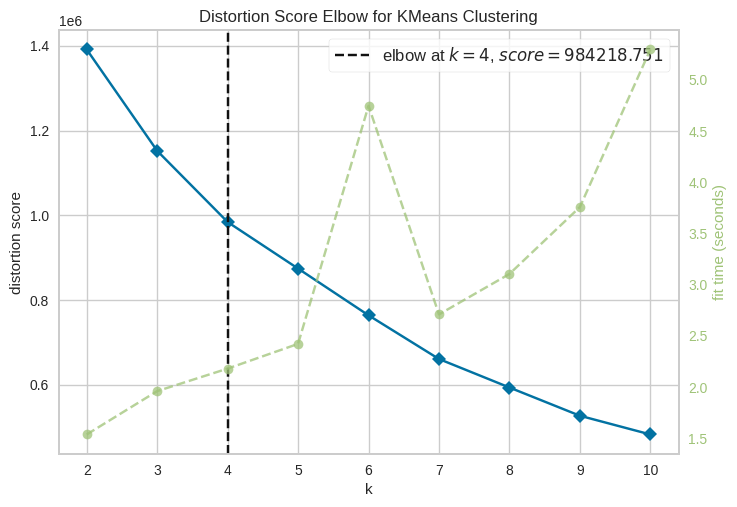

In [27]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(seg_transform)
Elbow_M.show();

# Silhouette

In [ ]:
# from sklearn.metrics import silhouette_score, silhouette_samples
# from matplotlib import cm

# # Generating the sample data
# X = seg_transform
# n_samples, n_features = X.shape
# centers = 6
# cluster_std = 1

# range_n_clusters = [2, 3, 4, 5, 6, 7]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1 to 1, but in this example, all
#     # values lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed clusters.
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to cluster i and sort them
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for the next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for the average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the y-axis labels/ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd plot showing the actual clusters formed
#     colors = cm

# K-Means

In [28]:
# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit model and predict clusters
yhat = kmeans.fit_predict(seg_transform)

In [30]:
# create a new column in the scaled dataframe with the cluster labels
seg_kmean = pd.DataFrame(seg, columns=seg.columns)
seg_kmean["Clusters"] = pd.Series(yhat, index=seg_transform.index)
seg_kmean

# # Adding the Clusters feature to the original dataframe.
# seg["Clusters"] = seg_kmean["Clusters"]
# seg.head()

,frequency,Avg_spend,Discount,total_time,mtbp,trans_type_offline,trans_type_online,Clusters
0,2,4.115000e+05,0.000000,57,28.500000,1,1,0
1,2,1.899000e+06,0.000000,84,42.000000,0,2,0
2,11,4.162727e+05,0.000000,94,8.545455,8,3,0
3,1,4.100000e+05,0.000000,1,1.000000,1,0,3
4,3,8.558333e+05,0.000000,32,10.666667,2,1,0
...,...,...,...,...,...,...,...,...
325622,20,1.125350e+06,1.521679,156,7.800000,15,5,2
325623,2,6.415000e+05,0.000000,62,31.000000,2,0,0
325624,15,5.108667e+05,0.000000,164,10.933333,15,0,0
325625,1,5.000000e+04,0.000000,1,1.000000,1,0,3


In [31]:
df_segm_analysis = seg_kmean.groupby(["Clusters"]).mean()
df_segm_analysis

,frequency,Avg_spend,Discount,total_time,mtbp,trans_type_offline,trans_type_online
Clusters,,,,,,,
0,4.426789,7.089575e+05,0.013763,56.385628,13.999616,2.567496,1.859293
1,1.123947,1.465259e+06,2.308402,1.119682,0.999641,0.432147,0.691801
2,7.565704,9.869315e+05,2.610466,102.786512,17.452615,3.423275,4.142428
3,1.940381,6.153908e+05,0.345657,1.697077,0.890200,1.707388,0.232993


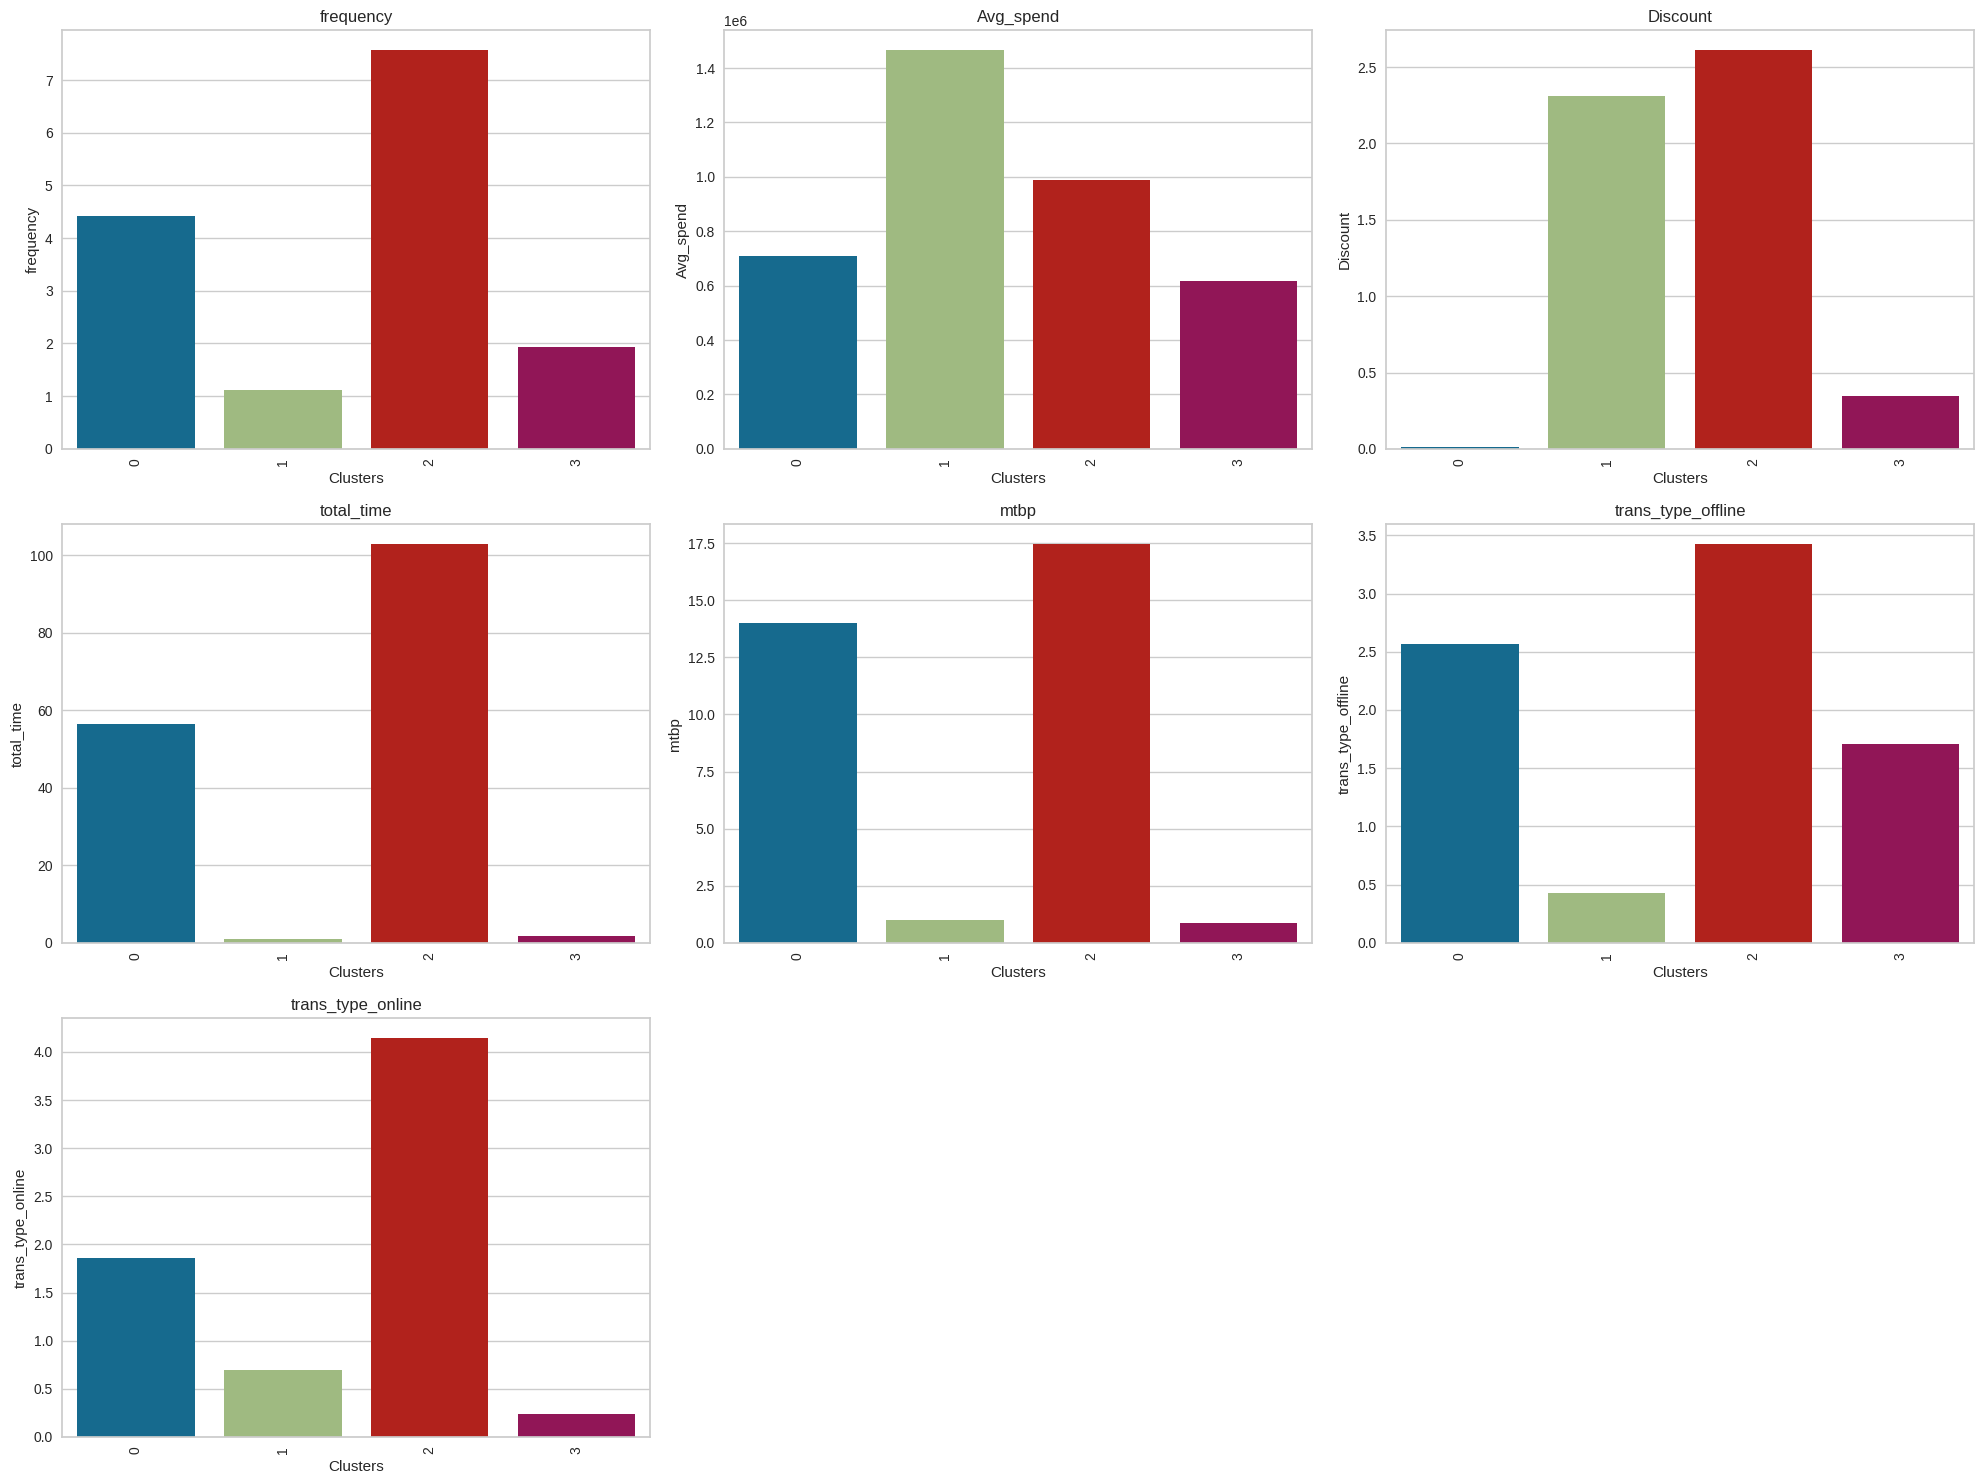

In [32]:
def bar_plot(df):
    # 3 columns
    num_cols = len(df.columns)
    num_rows = (num_cols + 2) // 3  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 3, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=col, data=df, ax=ax[i//3, i%3])
        ax[i//3, i%3].set_title(col)
        ax[i//3, i%3].set_xticklabels(df.index, rotation=90)

    # Remove any unused subplots
    if num_cols < num_rows * 3:
        for j in range(num_cols % 3, 3):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

bar_plot(df_segm_analysis)

### Labeling

# Principle Component Analysis

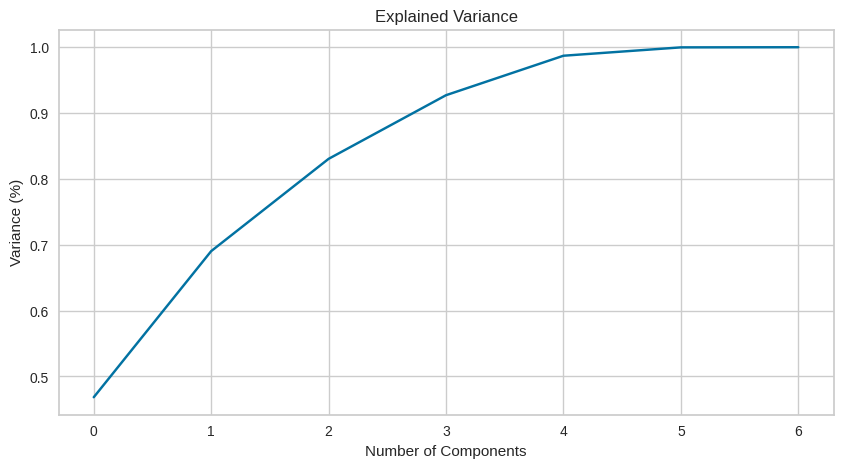

In [33]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(seg_transform)
pca.explained_variance_ratio_

# Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

rule of thumb is to keep at least 70 to 80 percent of the explained variance.
So Let’s keep the first 2 components for our further analysis.

In [34]:
pca = PCA(n_components=2)
pca.fit(seg_transform)
print("explained_variance_ratio_:", pca.explained_variance_ratio_)

PCA_ds = pd.DataFrame(pca.transform(seg_transform), columns=(["PC1","PC2"]))
PCA_ds.describe().T

explained_variance_ratio_: [0.46846483 0.22187253]


,count,mean,std,min,25%,50%,75%,max
PC1,325627.0,-7.820559e-17,1.810874,-3.462556,-1.655434,-0.610140,1.603978,4.050077
PC2,325627.0,-6.703336e-17,1.246239,-4.149029,-1.051123,0.006683,0.921825,10.402511


,frequency,Avg_spend,Discount,total_time,mtbp,trans_type_offline,trans_type_online
PC-1,0.498690,-0.092199,0.180504,0.536486,0.491074,0.257748,0.338852
PC-2,-0.171568,0.467571,0.497711,-0.007288,0.076720,-0.554549,0.436764


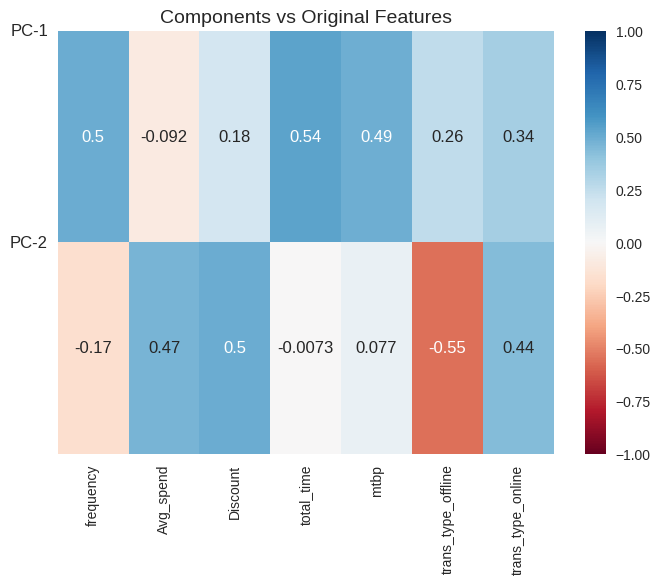

In [35]:
df_pca_comp = pd.DataFrame(pca.components_,columns=seg_transform.columns,index = ['PC-1','PC-2'])
display(df_pca_comp)

# heatmap
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0,1],['PC-1','PC-2'], rotation = 360, fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [36]:
PCA_ds["Clusters"] = yhat
PCA_ds

,PC1,PC2,Clusters
0,1.485900,-0.328483,0
1,1.219682,1.769205,0
2,3.053123,-1.492262,0
3,-1.842107,-0.913107,3
4,1.574778,-0.392424,0
...,...,...,...
325622,3.773967,0.007990,2
325623,1.145000,-1.080201,0
325624,2.629791,-2.744835,0
325625,-1.718772,-1.538580,3


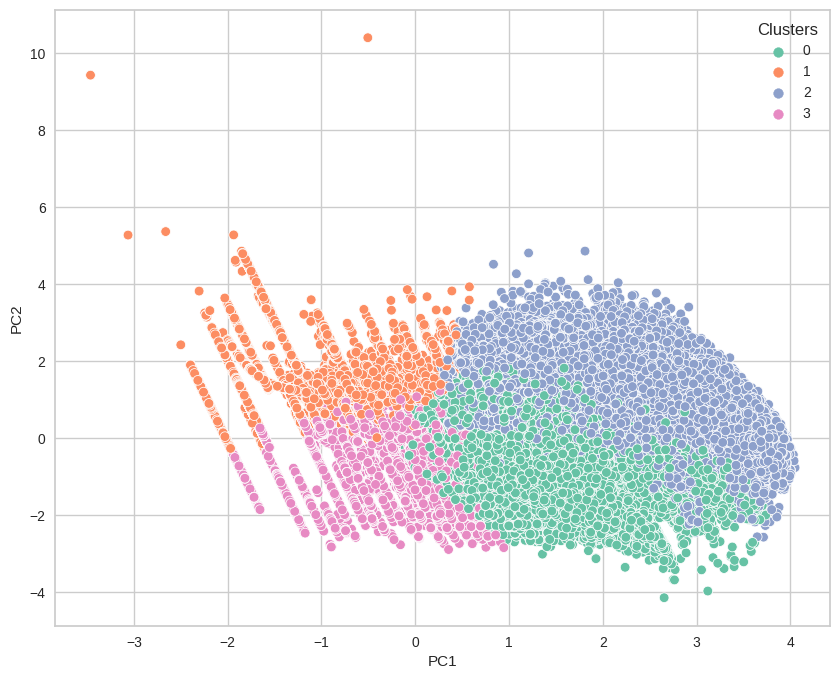

In [37]:
# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=PCA_ds, palette="Set2")
plt.show()

In [38]:
seg_reslut=pd.concat([features.iloc[:,0:1],seg], axis=1)

In [39]:
seg_reslut.head()

,ent,frequency,Avg_spend,Discount,total_time,mtbp,trans_type_offline,trans_type_online,Clusters
0,8C4ECCCCC3Y,2,4.115000e+05,0.0,57,28.500000,1,1,0
1,8CCCCCC4R1F,2,1.899000e+06,0.0,84,42.000000,0,2,0
2,BC11JW3U,11,4.162727e+05,0.0,94,8.545455,8,3,0
3,BCCCCRE3CZY,1,4.100000e+05,0.0,1,1.000000,1,0,3
4,BCCCCREW3WY,3,8.558333e+05,0.0,32,10.666667,2,1,0


# Feature Selection

In [40]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# split data into train and test sets
X = seg_transform
y = pd.DataFrame(yhat)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
# print(y_train.value_counts(normalize=True))
# print(y_test.value_counts(normalize=True))

In [41]:
rfc = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(np.array(X), np.array(y))

# Important features
important = list(X.columns[boruta_selector.support_])
print("Important features:", important)

# Tentative features
tentative = list(X.columns[boruta_selector.support_weak_])
print("Tentative features:", tentative)

# Unimportant features
unimportant = list(X.columns[~(boruta_selector.support_ | boruta_selector.support_weak_)])
print("Unimportant features:", unimportant)



Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	0
Important features: ['frequency', 'Avg_spend', 'Discount', 'total_time', 'mtbp', 'trans_type_offline', 'trans_type_online']
Tentative features: []
Unimportant features: []


# Feature importance

In [42]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

3    0.308544
1    0.274997
0    0.267101
2    0.149358
dtype: float64
3    0.308556
1    0.274990
0    0.267098
2    0.149357
dtype: float64


In [43]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9984184503884778


In [44]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

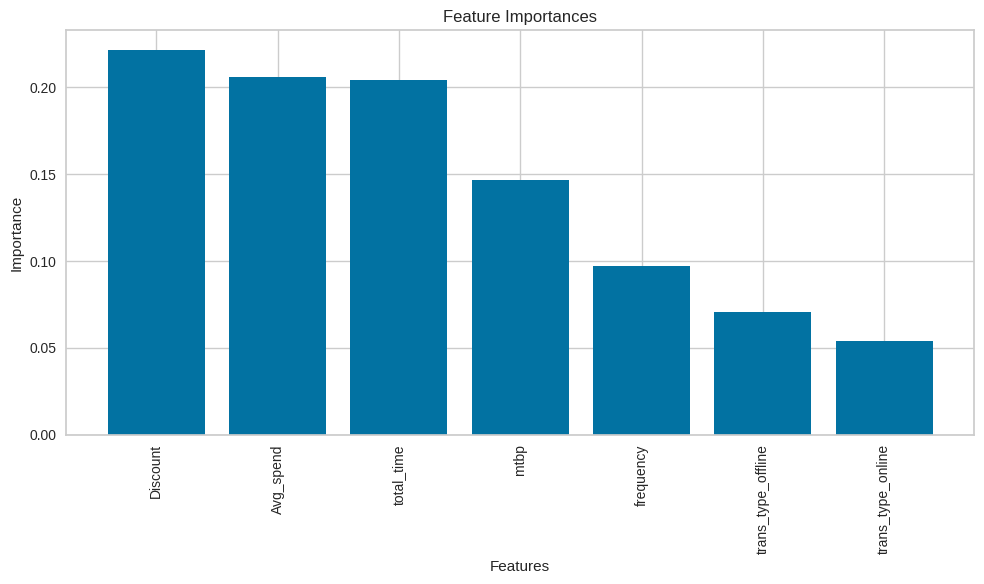

In [45]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Random Forest

In [46]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [47]:
# Load dataset and split it into features (X) and target variable (y)
X = seg_reslut.drop(columns=['ent',
                             'Clusters',])
y = seg_reslut['Clusters']

In [48]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9985259343426588


In [50]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

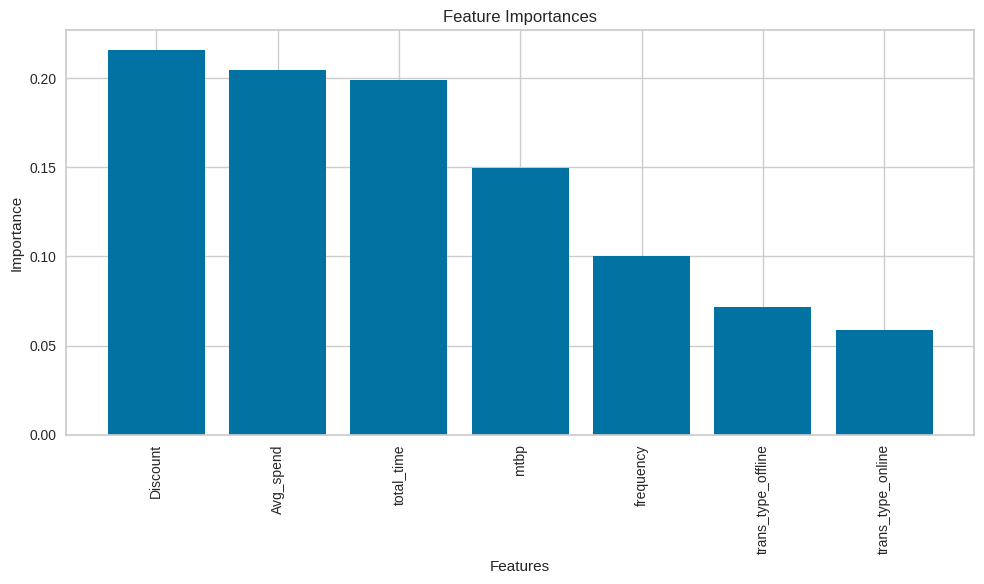

In [51]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [55]:
# Save the model to a file
joblib.dump(kmeans, '/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/Cust_Seg_kmeans_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/Cust_Seg_kmeans_model.pkl']

In [ ]:
# df_test.head().loc[:,["product", "1ECZ", "8CEC4Q", "4E4W"]]
#df_test.to_csv()

In [ ]:
#tns=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/trans_21_23.csv')

In [ ]:
#df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/trans_21_23.csv', index=False)
#files.download('/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Customer Segmentation/trans_21_23.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_test.iloc[0:1,8:9]=1
# df_test.iloc[0:1,:]